In [6]:
# This script is written by ixScience and can be found here 
# https://github.com/ixScience/fourier_neural_operator/blob/master/data_generation/navier_stokes/ns_2d.py

import torch
import math
from timeit import default_timer
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

pathToProject = '/home/diya/Projects/flow_super_resolution/dataset/ns_2d_data/'
gpu = True # Set to true if CUDA is available

from random_fields import GaussianRF

In [12]:
#w0: initial vorticity
#f: forcing term
#visc: viscosity (1/Re)
#T: final time
#delta_t: internal time-step for solve (descrease if blow-up)
#record_steps: number of in-time snapshots to record
def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1):

    #Grid size - must be power of 2
    N = w0.size()[-1]

    #Maximum frequency
    k_max = math.floor(N/2.0)

    #Number of steps to final time
    steps = math.ceil(T/delta_t)

    #Initial vorticity to Fourier space
    w_h = torch.fft.rfft2(w0)

    #Forcing to Fourier space
    f_h = torch.fft.rfft2(f)

    #If same forcing for the whole batch
    if len(f_h.size()) < len(w_h.size()):
        f_h = torch.unsqueeze(f_h, 0)

    #Record solution every this number of steps
    record_time = math.floor(steps/record_steps)

    #Wavenumbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=w0.device)), 0).repeat(N,1)
    #Wavenumbers in x-direction
    k_x = k_y.transpose(0,1)

    #Truncate redundant modes
    k_x = k_x[..., :k_max + 1]
    k_y = k_y[..., :k_max + 1]

    #Negative Laplacian in Fourier space
    lap = 4*(math.pi**2)*(k_x**2 + k_y**2)
    lap[0,0] = 1.0
    #Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float(), 0)

    #Saving solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)

    #Record counter
    c = 0
    #Physical time
    t = 0.0
    for j in tqdm(range(steps)):
        #Stream function in Fourier space: solve Poisson equation
        psi_h = w_h / lap

        #Velocity field in x-direction = psi_y
        q = 2. * math.pi * k_y * 1j * psi_h
        q = torch.fft.irfft2(q, s=(N, N))

        #Velocity field in y-direction = -psi_x
        v = -2. * math.pi * k_x * 1j * psi_h
        v = torch.fft.irfft2(v, s=(N, N))

        #Partial x of vorticity
        w_x = 2. * math.pi * k_x * 1j * w_h
        w_x = torch.fft.irfft2(w_x, s=(N, N))

        #Partial y of vorticity
        w_y = 2. * math.pi * k_y * 1j * w_h
        w_y = torch.fft.irfft2(w_y, s=(N, N))

        #Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.rfft2(q*w_x + v*w_y)

        #Dealias
        F_h = dealias* F_h

        #Crank-Nicolson update
        w_h = (-delta_t*F_h + delta_t*f_h + (1.0 - 0.5*delta_t*visc*lap)*w_h)/(1.0 + 0.5*delta_t*visc*lap)

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = torch.fft.irfft2(w_h, s=(N, N))

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1


    return sol, sol_t

if gpu:
    device = torch.device('cuda') 
else:
    device = torch.device('cpu')

#Resolution
s = 1024

#Number of solutions to generate
N = 20

#Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=2.5, tau=7, device=device)

#Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
t = torch.linspace(0, 1, s+1, device=device)
t = t[0:-1]

X,Y = torch.meshgrid(t, t, indexing='ij')
f = 0.1*(torch.sin(2*math.pi*(X + Y)) + torch.cos(2*math.pi*(X + Y)))

#Number of snapshots from solution

#Inputs
record_steps = 10
a = torch.zeros(N, s, s)
#Solutions
u = torch.zeros(N, s, s, record_steps)

#Solve equations in batches (order of magnitude speed-up)

#Batch size
bsize = 10

T = 50.0
viscosity = 1e-3
delta_t = 1e-4


# steps = math.ceil(T/delta_t)
# recordTime = math.floor(steps/record_steps)


c = 0
t0 =default_timer()
for j in range(N//bsize):

    #Sample random feilds
    w0 = GRF.sample(bsize)

    #Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, viscosity, T, delta_t, record_steps)

    a[c:(c+bsize),...] = w0
    u[c:(c+bsize),...] = sol

    c += bsize
    t1 = default_timer()
    print(j, c, t1-t0)


%cd
%cd $pathToProject/datasets
scipy.io.savemat('ns_2d_data_test.mat', mdict={'a': a.cpu().numpy(), 'u': u.cpu().numpy(), 't': sol_t.cpu().numpy()})
np.save('u_2d_test', u)
u.shape

100%|██████████| 500000/500000 [47:50<00:00, 174.19it/s]


0 10 2870.444815538125


100%|██████████| 500000/500000 [47:50<00:00, 174.20it/s]


1 20 5740.783536378061
/home/diya
/home/diya/Projects/flow_super_resolution/dataset/ns_2d_data/datasets


torch.Size([20, 1024, 1024, 10])

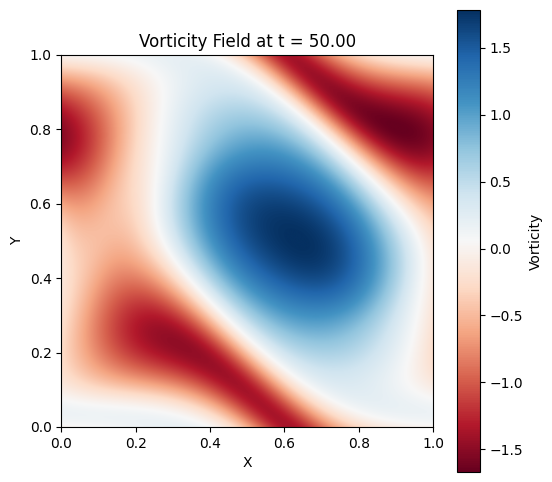

In [15]:
# Load data
data = scipy.io.loadmat('ns_2d_data_test.mat')
u = data['u']  # Shape: (N, s, s, record_steps)
t = data['t'].flatten()  # Ensure t is a 1D array

# Select a sample index
sample_idx = 0  # Change to view different samples

# Select a time step
time_idx = -1  # Last time step

# Extract the vorticity field
vorticity = u[sample_idx, :, :, time_idx]
# Extract the time value
time_value = t[time_idx]  # Ensure t[time_idx] is a scalar
# Extract the spatial grid
x = np.linspace(0, 1, u.shape[1])

# Create a meshgrid for plotting
X, Y = np.meshgrid(x, x)

# Plot the vorticity field
plt.figure(figsize=(6, 6))
plt.imshow(vorticity, cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(label='Vorticity')
plt.title(f"Vorticity Field at t = {float(t[time_idx]):.2f}")  # Ensure t[time_idx] is a scalar
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [16]:
import torch.nn.functional as F

# Convert to torch tensor and ensure proper dtype and device
u_tensor = torch.tensor(u, dtype=torch.float32)

# Select last time step as HR frame
u_hr = u_tensor[..., -1]  # Shape: (N, 1024, 1024)

# Downsample (e.g., to 256x256)
u_lr = F.interpolate(u_hr.unsqueeze(1), size=(16, 16), mode='bicubic', align_corners=False).squeeze(1)

print("HR shape:", u_hr.shape)  # (N, 1024, 1024)
print("LR shape:", u_lr.shape)  # (N, 256, 256)


HR shape: torch.Size([20, 1024, 1024])
LR shape: torch.Size([20, 16, 16])


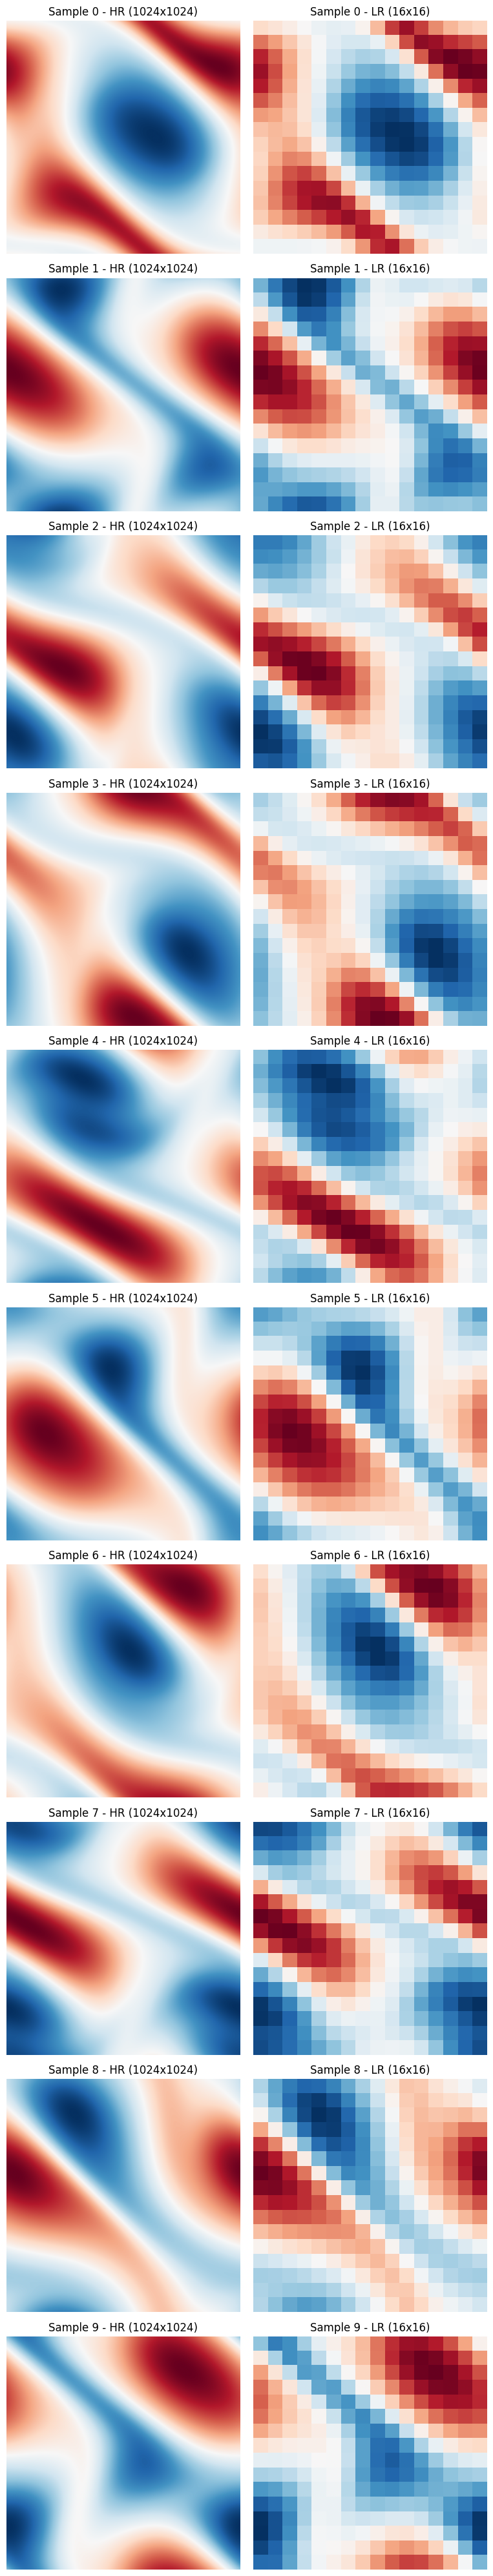

In [17]:
import scipy.io
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load data
data = scipy.io.loadmat('ns_2d_data_test.mat')
u = data['u']  # Shape: (N, s, s, record_steps)

# Parameters
num_samples = 10  # how many samples to visualize
time_idx = -1    # use last time step
downsample_to = 16  # e.g. LR = 256x256

# Extract HR vorticity at the chosen time step
u_hr = u[..., time_idx]  # Shape: (N, s, s)
u_hr_tensor = torch.tensor(u_hr, dtype=torch.float32).unsqueeze(1)  # Shape: (N, 1, s, s)

# Downsample to LR
u_lr_tensor = F.interpolate(u_hr_tensor, size=(downsample_to, downsample_to), mode='bicubic', align_corners=False)

# Plot samples
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4 * num_samples))

for i in range(num_samples):
    # HR
    ax_hr = axes[i, 0]
    ax_hr.imshow(u_hr_tensor[i, 0].cpu(), cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
    ax_hr.set_title(f'Sample {i} - HR ({u_hr_tensor.shape[-1]}x{u_hr_tensor.shape[-1]})')
    ax_hr.axis('off')

    # LR
    ax_lr = axes[i, 1]
    ax_lr.imshow(u_lr_tensor[i, 0].cpu(), cmap='RdBu', origin='lower', extent=[0, 1, 0, 1])
    ax_lr.set_title(f'Sample {i} - LR ({downsample_to}x{downsample_to})')
    ax_lr.axis('off')

plt.tight_layout()
plt.show()
